In [58]:
!pip install sktime
!pip install pmdarima

https://www.sktime.net/en/latest/users.html

Forecasting with sktime - https://www.sktime.net/en/latest/examples/01_forecasting.html

(No LSTM)

# Packages and plot functions

In [8]:
import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sktime

from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [9]:
np.random.seed(42)

plot_params = {'legend.fontsize': 20,
               'figure.figsize': (10, 8),
               'axes.labelsize':  15,
               'axes.titlesize':  20,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}

plt.style.use('seaborn-v0_8')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

In [10]:
def train_predict_plot(forecaster, fh, y_train, y_test, prophet=False, regression=False):

    if prophet:
        # Convert index to pd.DatetimeIndex
        z = y.copy()
        z = z.to_timestamp(freq="M")
        z_train, z_test = temporal_train_test_split(z, test_size=len(y_test))

        forecaster.fit(z_train)
        y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
        y_pred.index = y_test.index

    elif regression:
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)

    else:
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)

    plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Prediction"],
            colors=[color_dark_blue, color_light_blue, purple]);

    #print('MApE: {:.4f}'.format(mean_absolute_percentage_error(y_test, y_pred, symmetric=False)))

    return mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

# First Forecasting Example

In [78]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=2*12)

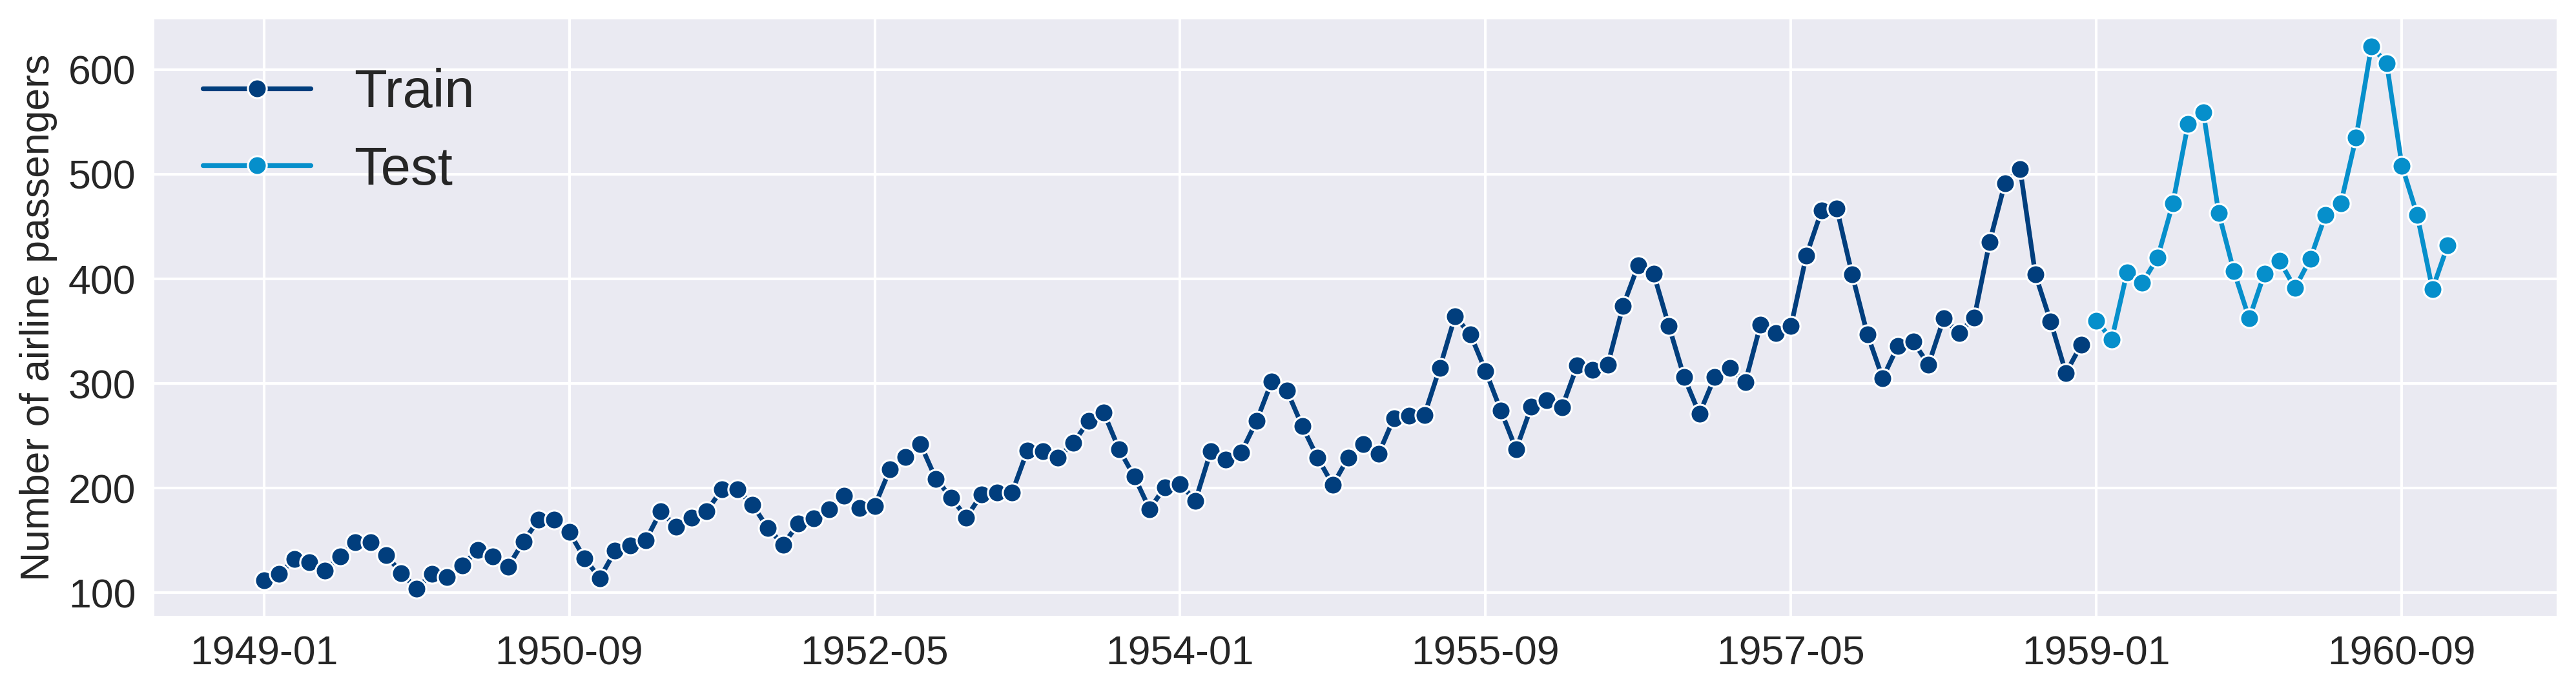

In [79]:
plot_series(y_train, y_test, labels=["Train", "Test"], colors=[color_dark_blue, color_light_blue]);

In [80]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [81]:
fh

ForecastingHorizon(['1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)

In [82]:
mape = pd.DataFrame(index=['mape'])

## Naive

In [83]:
naive_forecaster = NaiveForecaster(strategy="last")

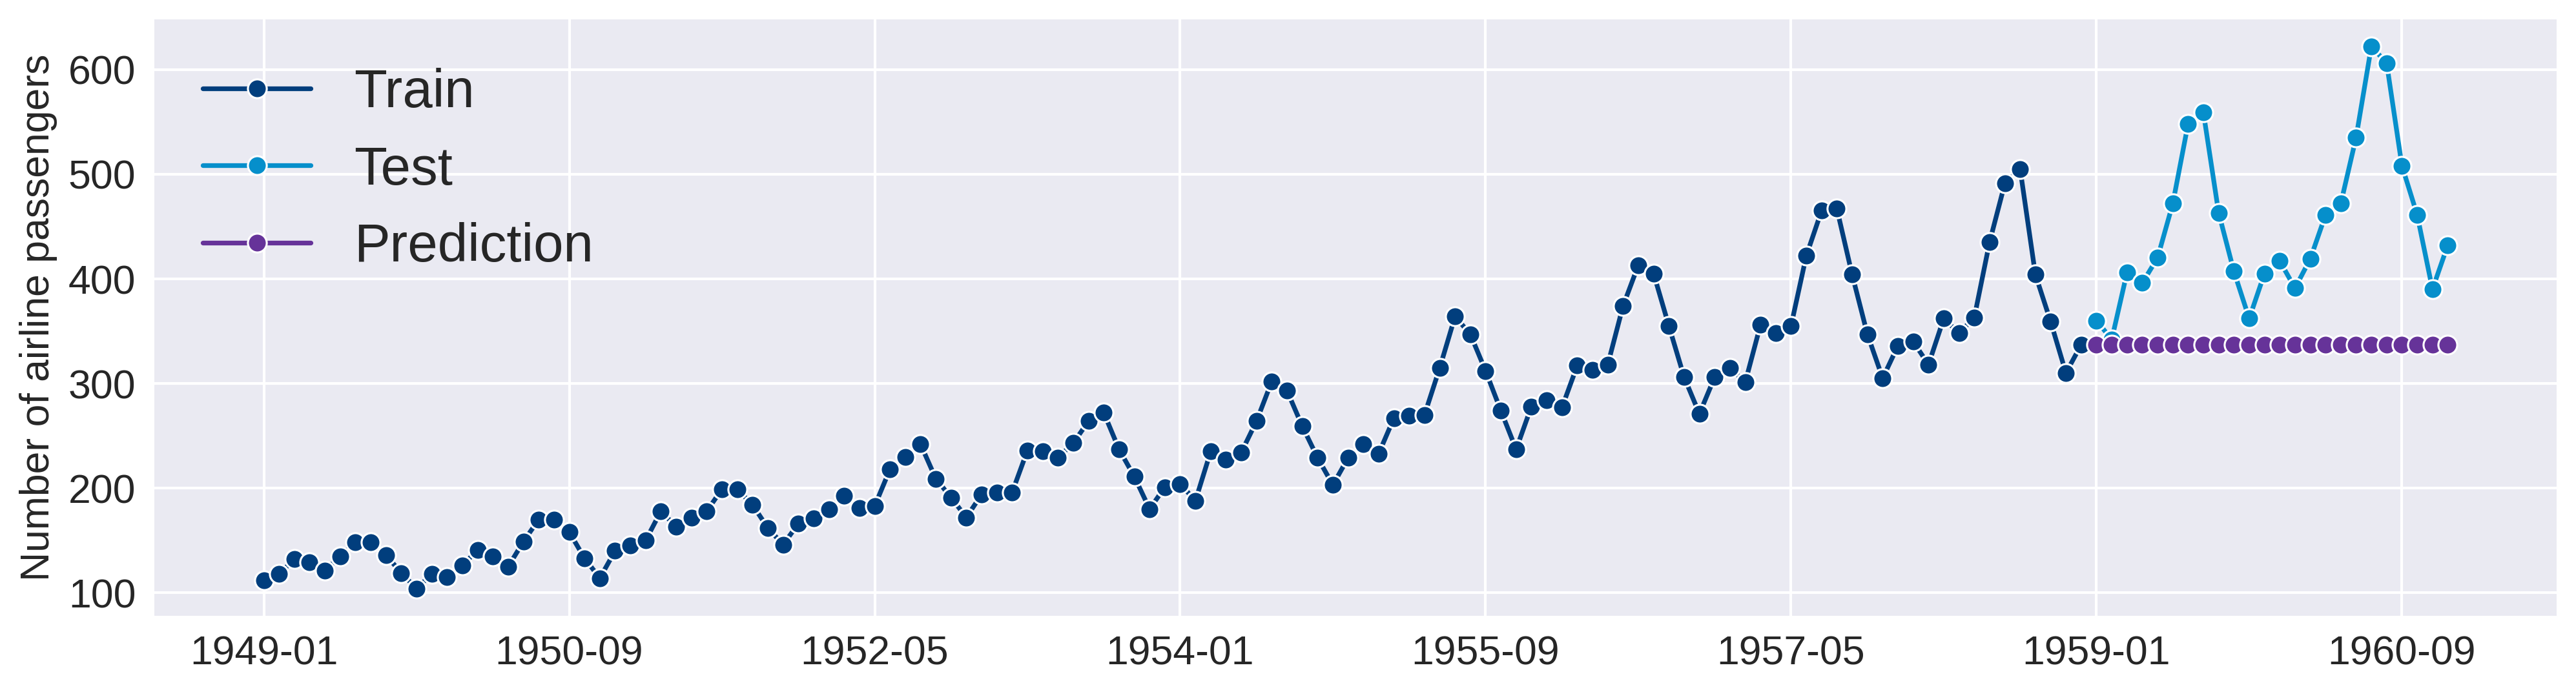

In [84]:
mape['Naive'] = train_predict_plot(naive_forecaster, fh, y_train, y_test)

In [85]:
# run for airline data
naive_sp_forecaster = NaiveForecaster(strategy="last", sp=12) #sp: Seasonal periodicity to use in the seasonal forecasting. None=1.

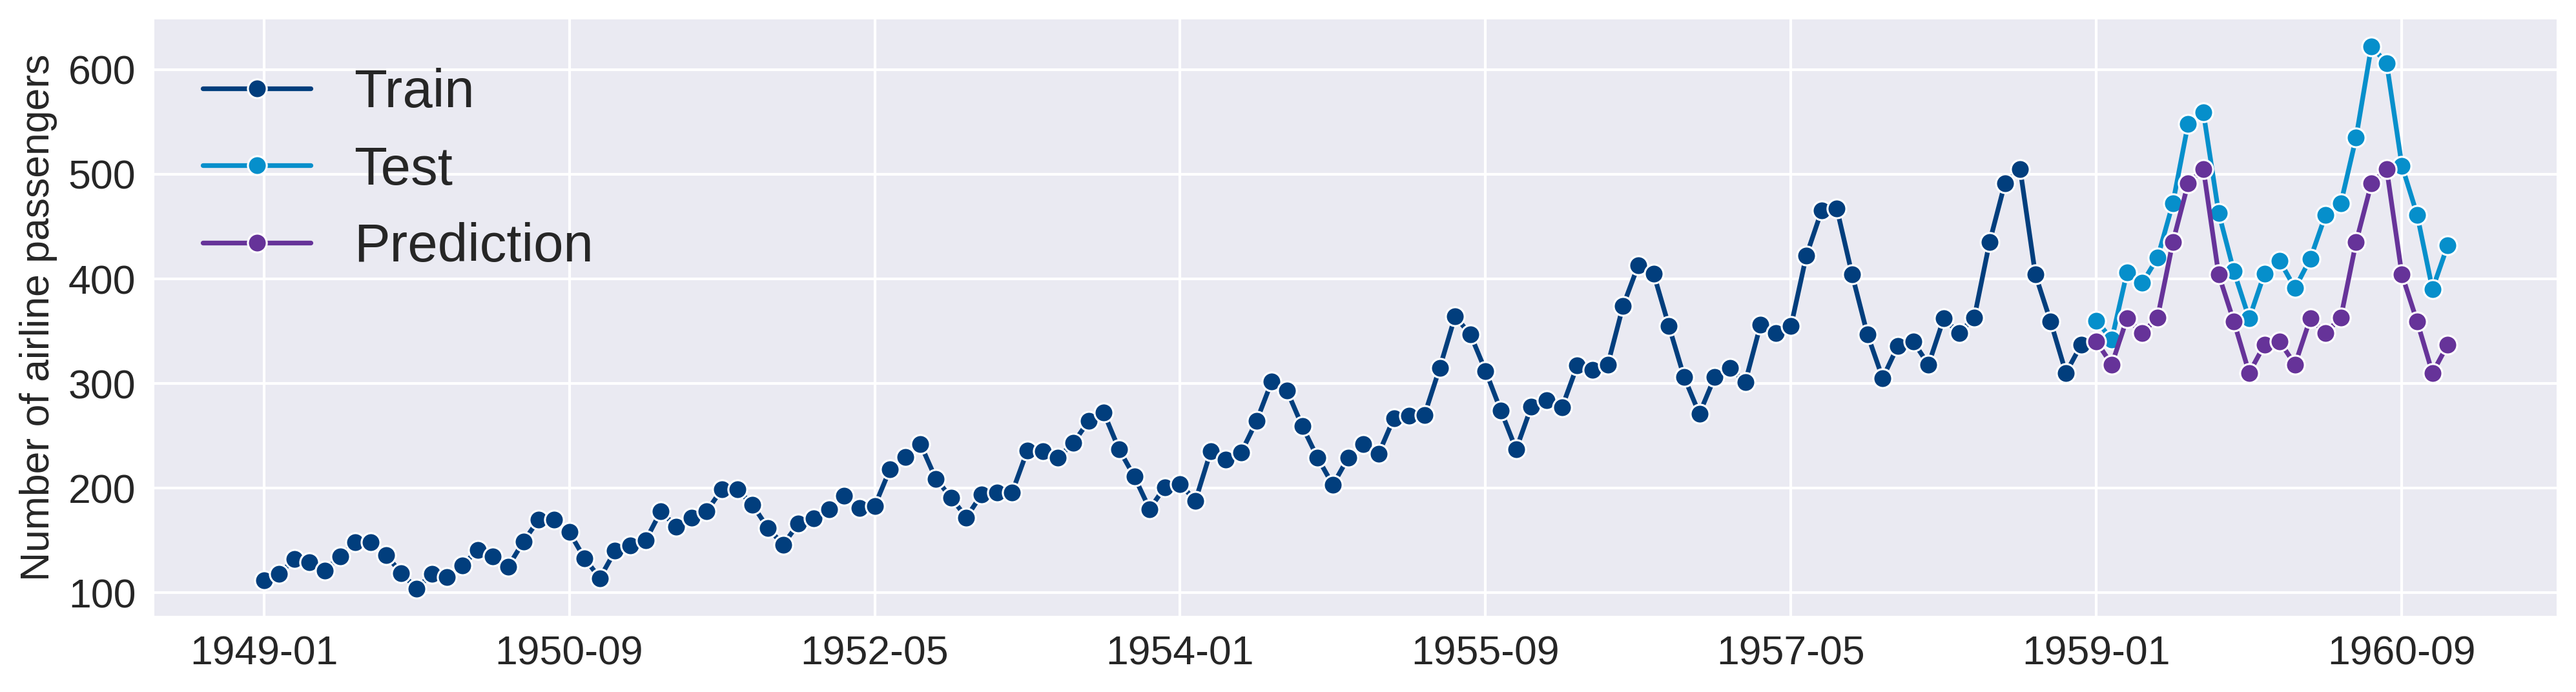

In [86]:
mape['Naive Seasonal'] = train_predict_plot(naive_sp_forecaster, fh, y_train, y_test)

##ARIMA

In [87]:
arima_forecaster = AutoARIMA(sp=12, suppress_warnings=True)

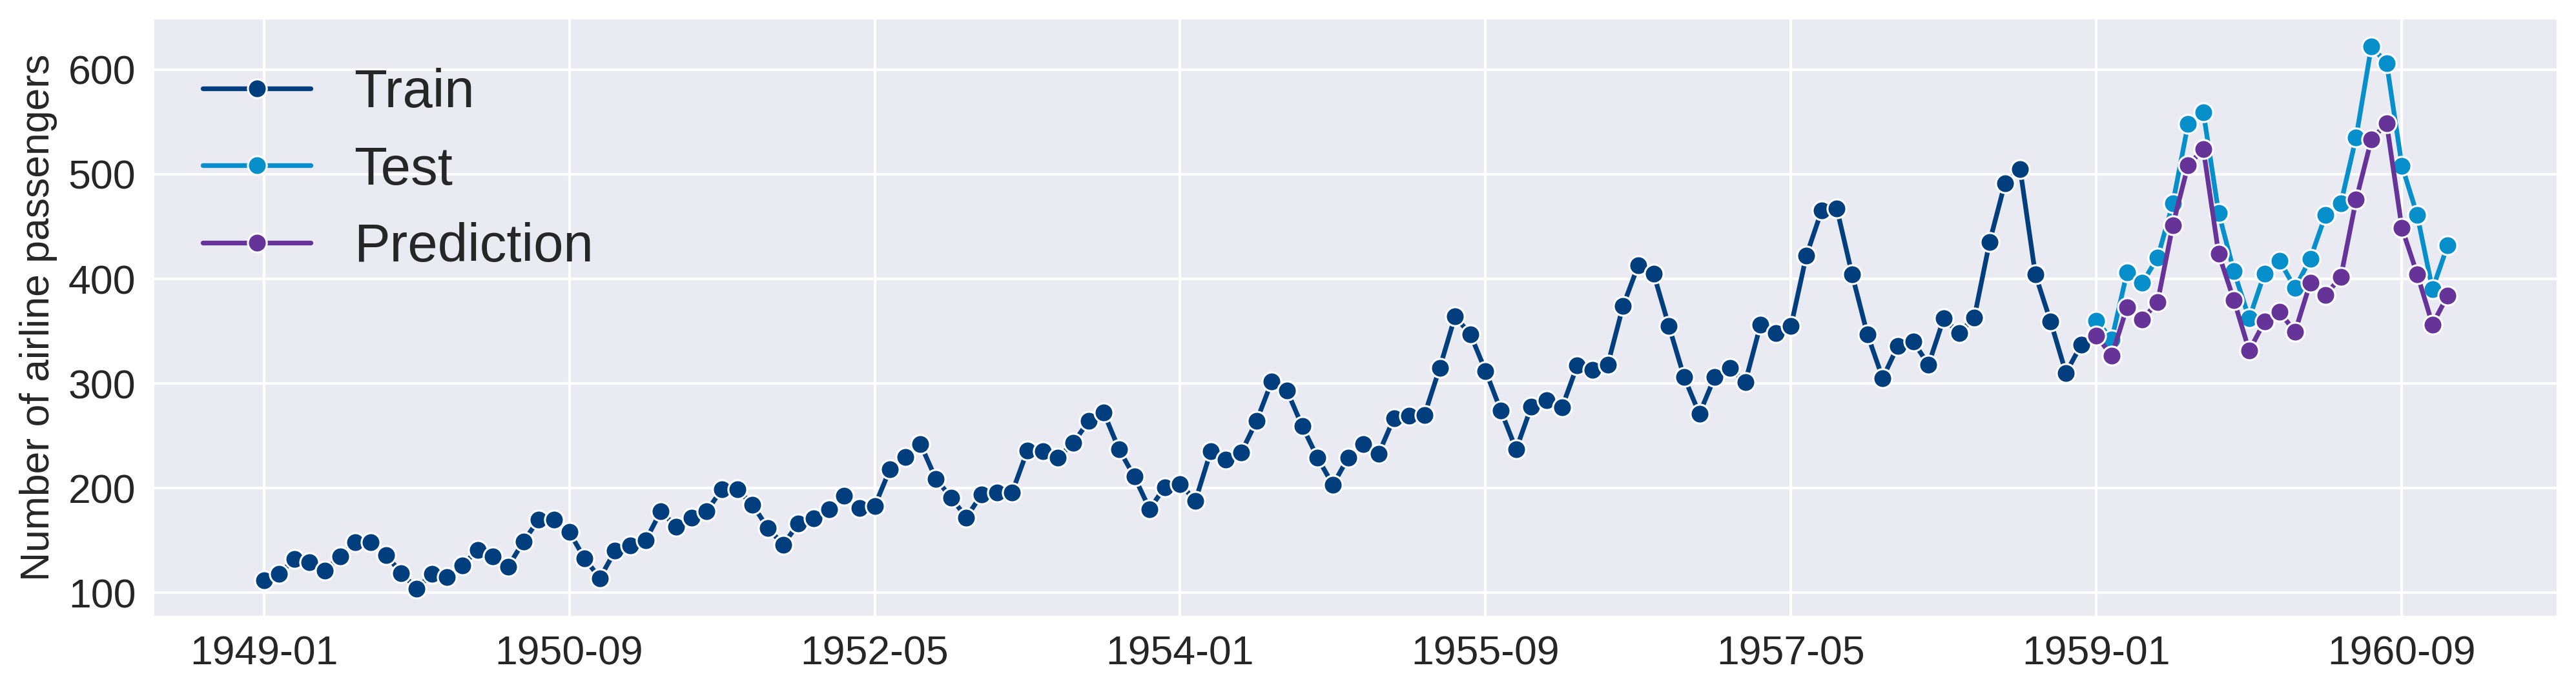

In [88]:
mape['ARIMA'] = train_predict_plot(arima_forecaster, fh, y_train, y_test)

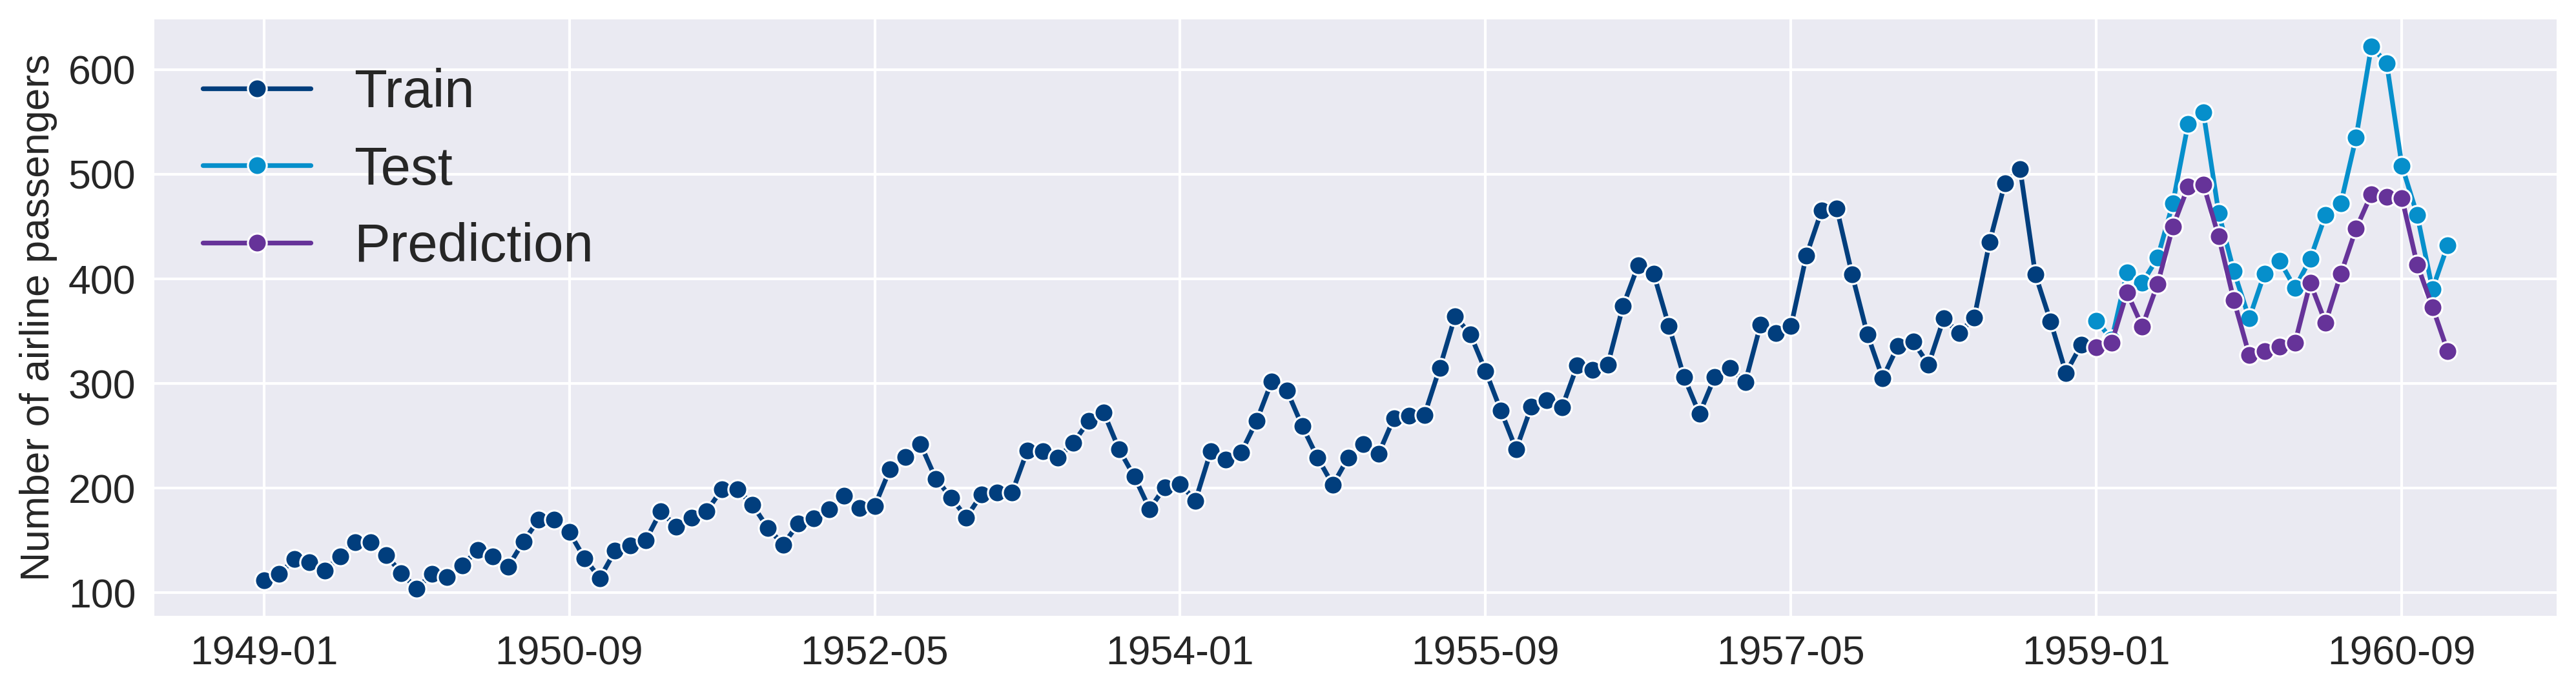

In [89]:
gb_regressor = GradientBoostingRegressor()
gb_forecaster = make_reduction(gb_regressor, window_length=3*12, strategy="recursive", windows_identical=False)

mape['Grad. Boosting'] = train_predict_plot(gb_forecaster, fh, y_train, y_test)

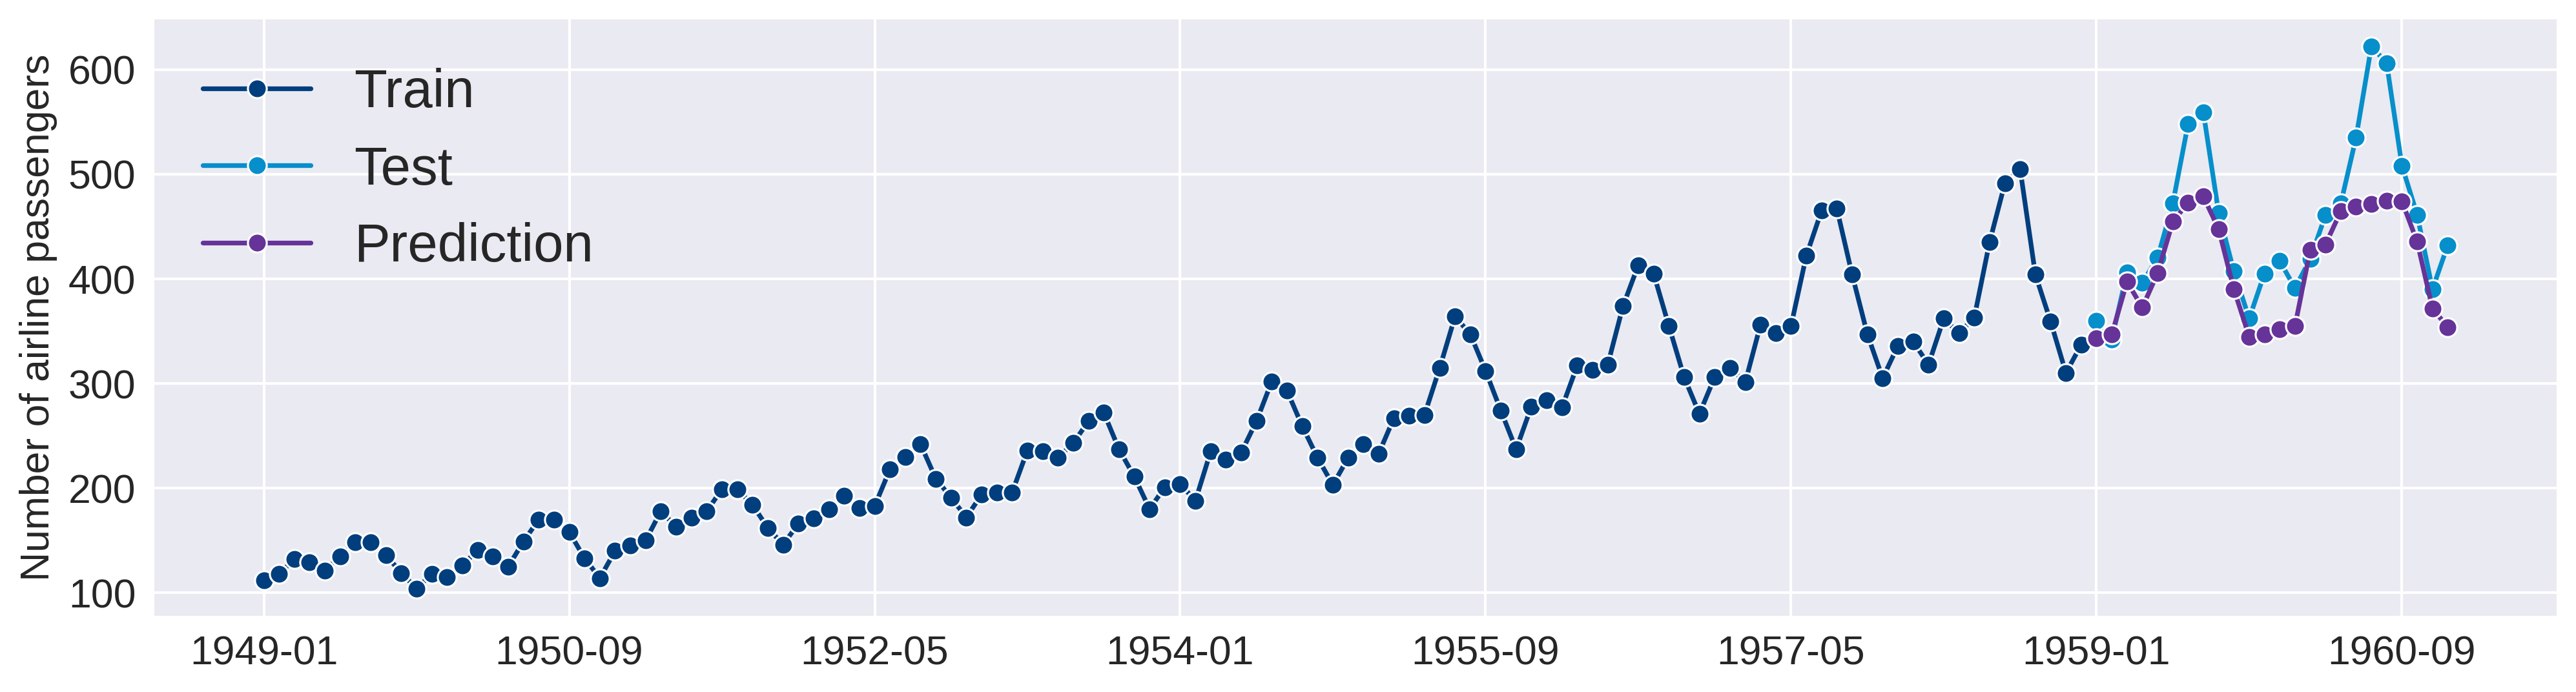

In [92]:
rf_regressor = RandomForestRegressor()
rf_forecaster = make_reduction(rf_regressor, window_length=3*12, strategy="recursive", windows_identical=False)

mape['RF'] = train_predict_plot(rf_forecaster, fh, y_train, y_test)

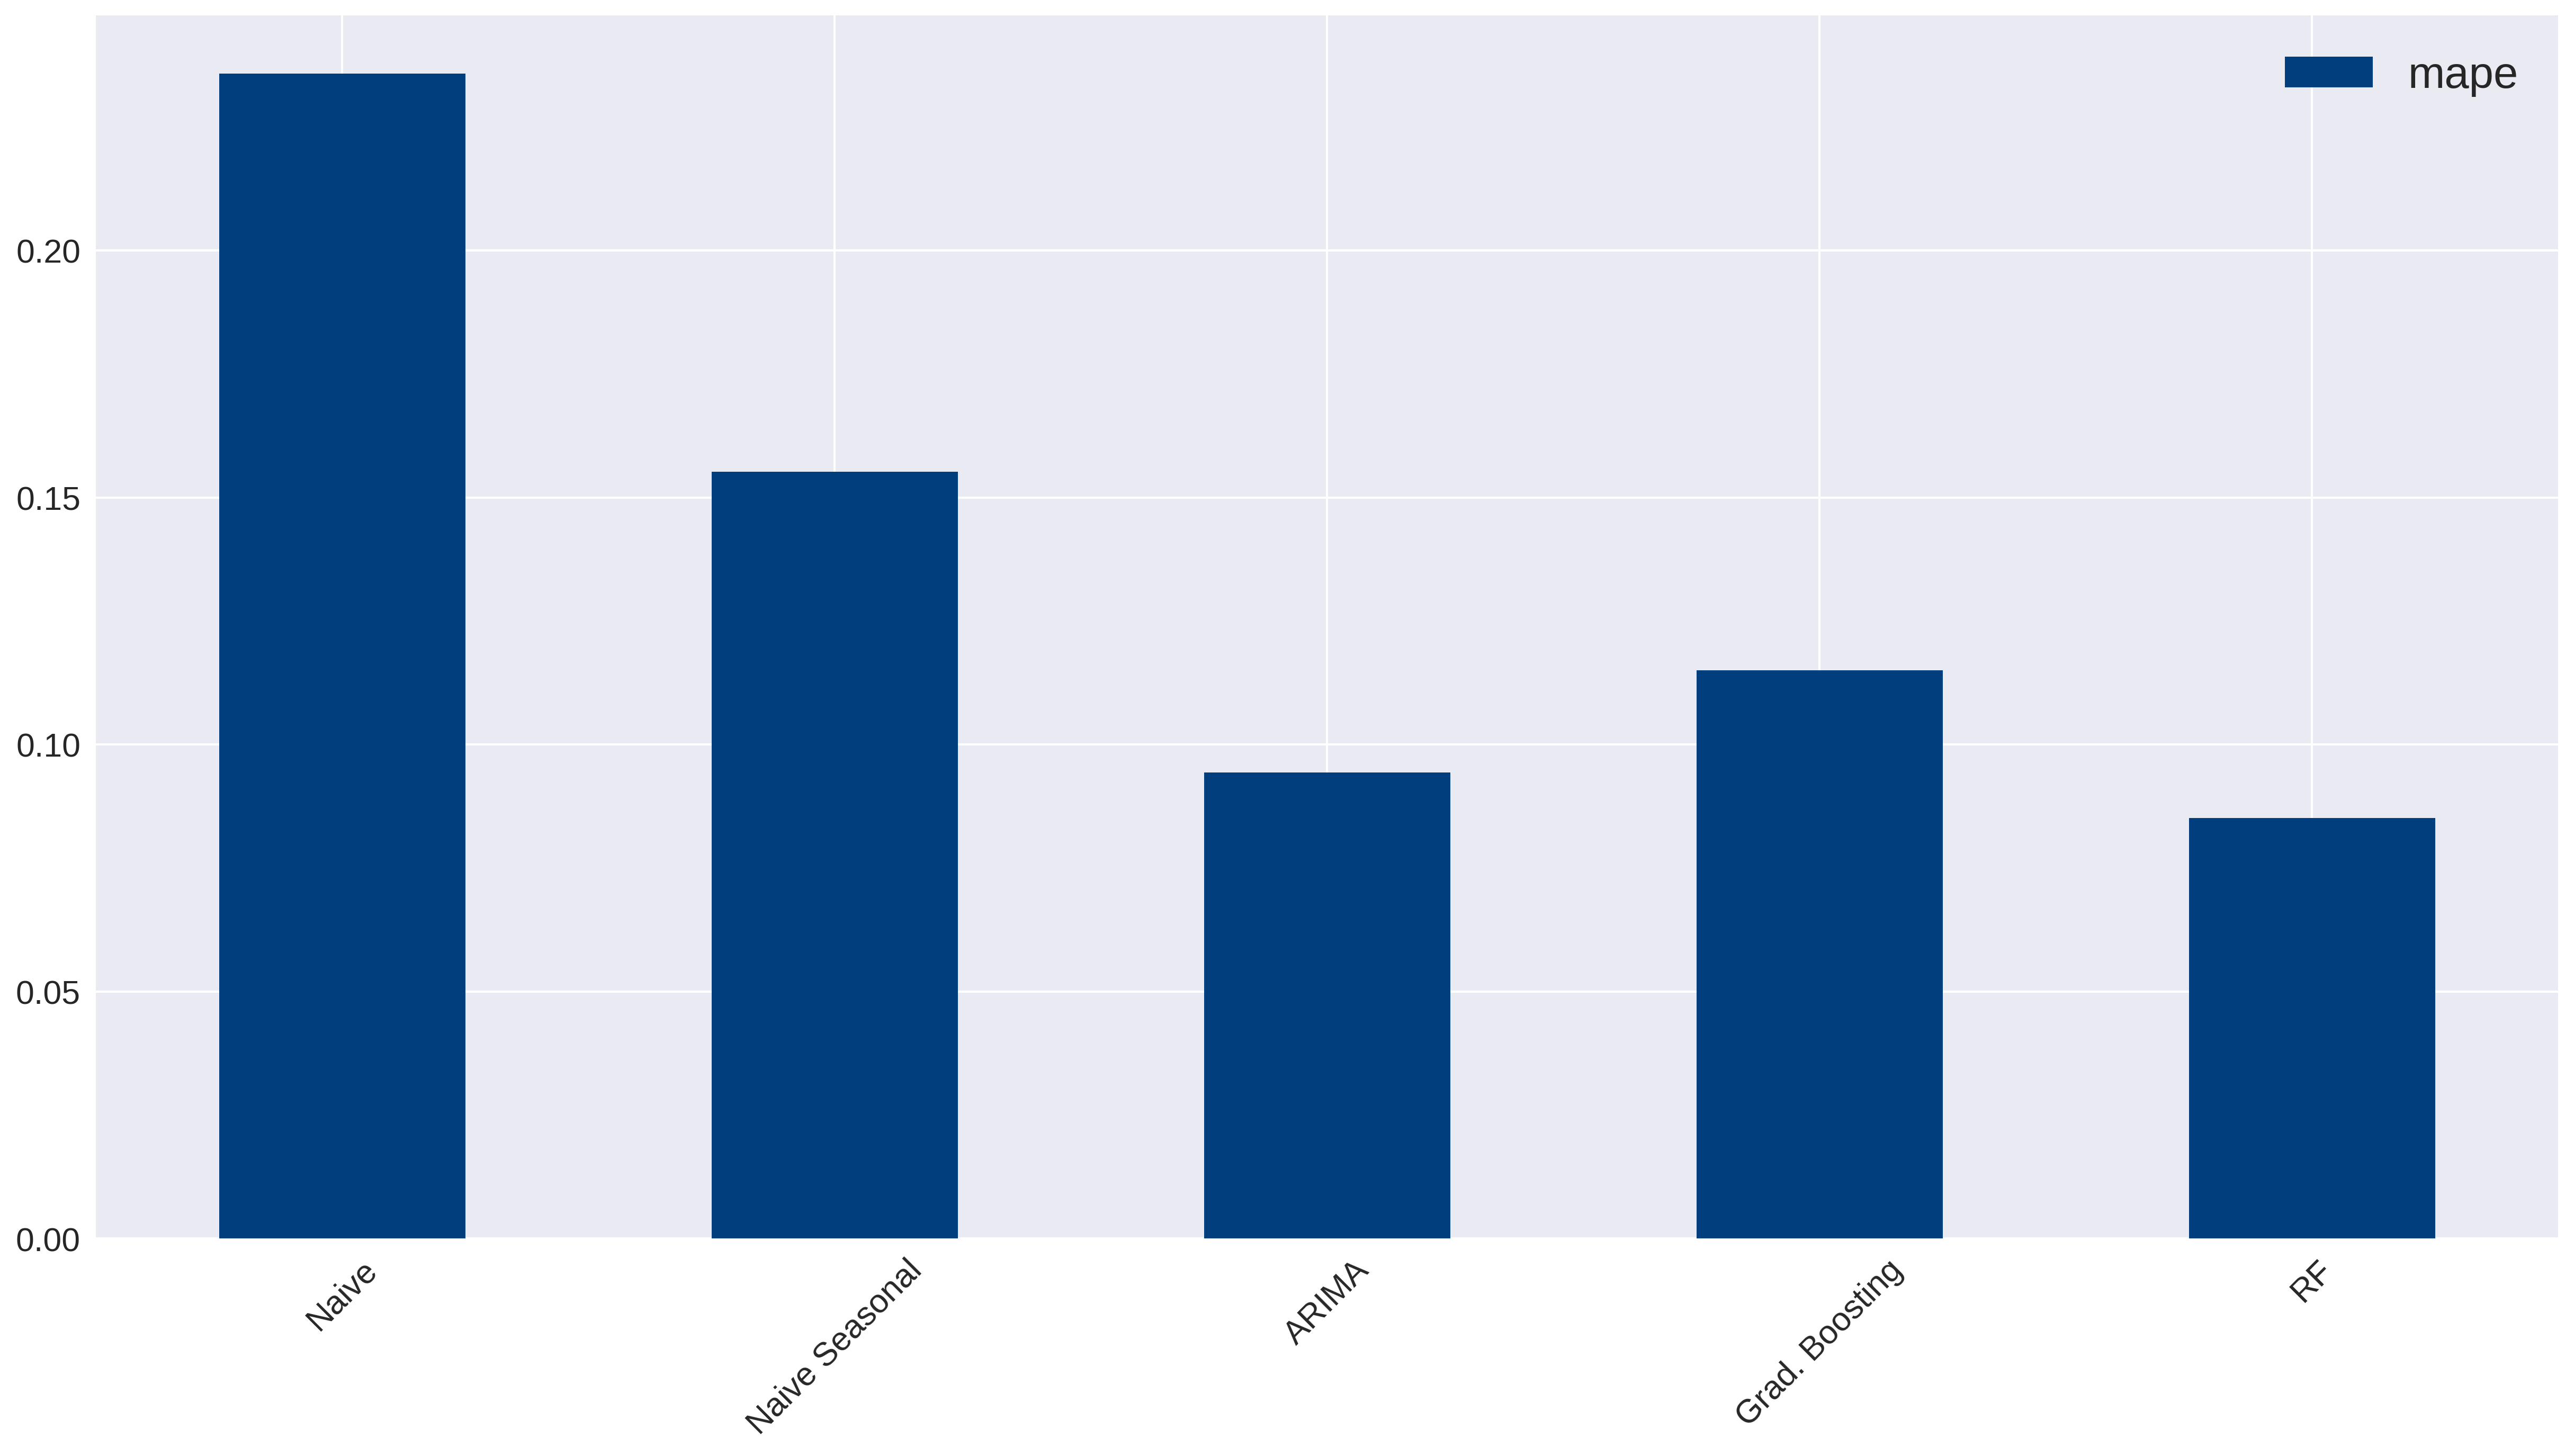

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
mape.T.plot.bar(rot=45, color=colors, ax=ax);

## ExpandingWindowSplitter

In [94]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter

In [95]:
cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=5*12
)

In [96]:
cv

ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                        initial_window=60, step_length=12)

In [97]:
df = evaluate(forecaster=arima_forecaster, y=y, cv=cv, strategy="refit", return_data=True)

In [98]:
df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.041717,9.637812,0.023180,60,1953-12
1,0.061710,11.230128,0.047309,72,1954-12
2,0.050042,12.071883,0.023952,84,1955-12
3,0.029802,14.403420,0.022369,96,1956-12
4,0.053773,5.877953,0.019373,108,1957-12
5,0.073820,10.023061,0.022814,120,1958-12
6,0.030976,21.779130,0.027443,132,1959-12


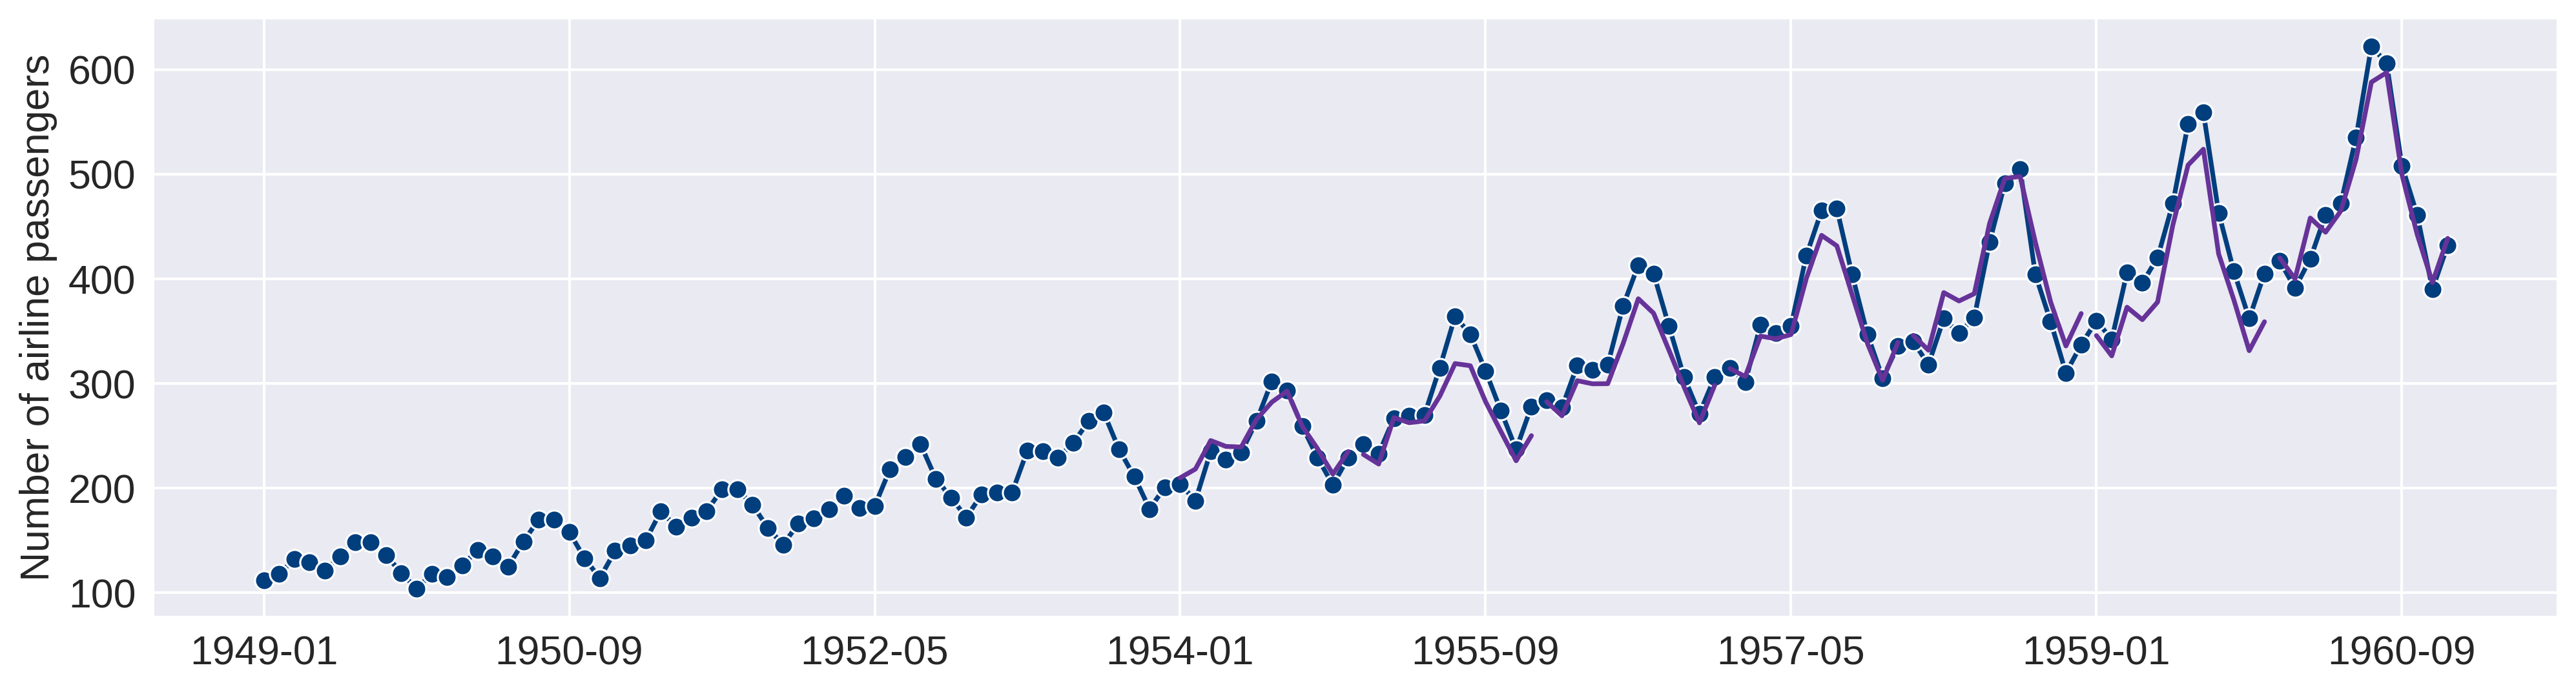

In [99]:
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    df["y_pred"].iloc[6],
    markers=["o"] + 7 * [""],
    #labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(7)],
    colors=[color_dark_blue] + 7 * [purple]
)
#ax.legend(fontsize=10);

## SlidingWindowSplitter

In [100]:
from sktime.split import SlidingWindowSplitter

In [101]:
cv = SlidingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=6*12,
    window_length=3*12-1
)

In [102]:
cv

SlidingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                      initial_window=72, step_length=12, window_length=35)

In [103]:
df = evaluate(forecaster=arima_forecaster, y=y, cv=cv, strategy="refit", return_data=True)

In [104]:
df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.061710,10.817822,0.023714,72,1954-12
1,0.025864,2.247615,0.019055,35,1955-12
2,0.024356,4.623427,0.038278,35,1956-12
3,0.074786,7.604581,0.029787,35,1957-12
4,0.108192,3.483007,0.028674,35,1958-12
5,0.047784,2.512470,0.019120,35,1959-12


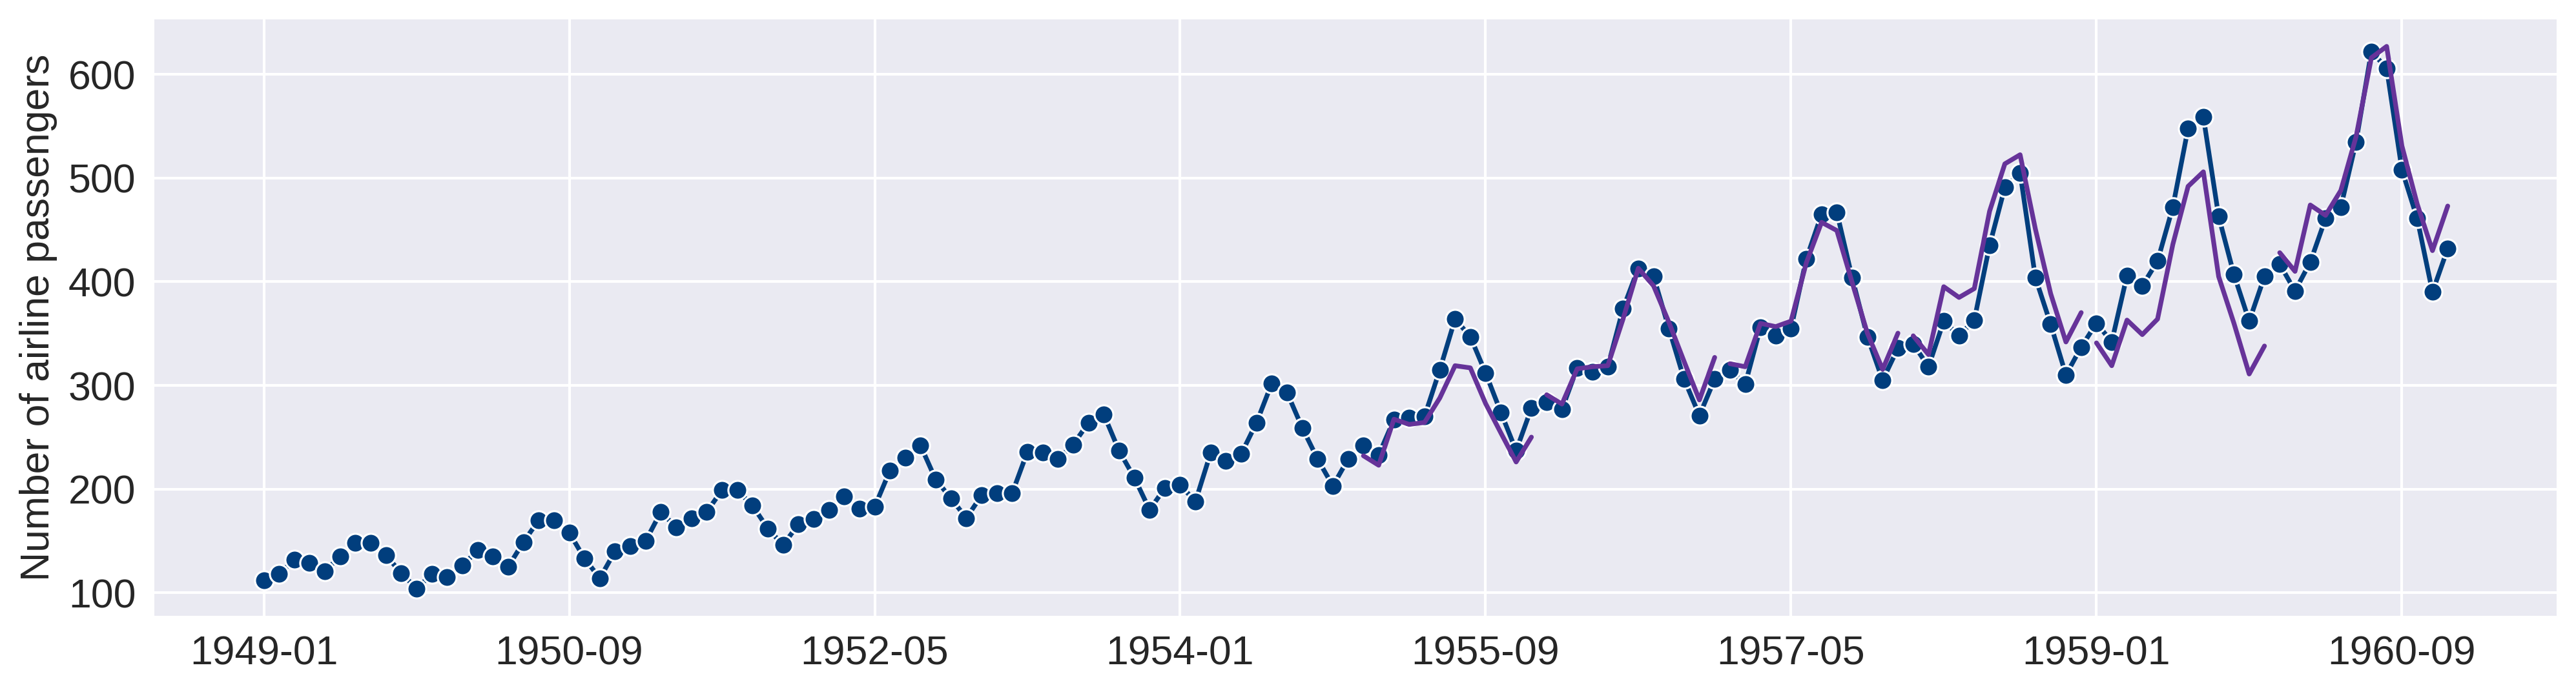

In [105]:
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o"] + 6 * [""],
    #labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(7)],
    colors=[color_dark_blue] + 6 * [purple]
)

In [106]:
gb_forecaster = make_reduction(gb_regressor, window_length=2*12-2, strategy="recursive", windows_identical=False)
df = evaluate(forecaster=gb_forecaster, y=y, cv=cv, strategy="refit", return_data=True)

In [107]:
df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.127226,0.092990,0.012053,72,1954-12
1,0.098195,0.064130,0.008699,35,1955-12
2,0.086895,0.106598,0.014890,35,1956-12
3,0.123535,0.100343,0.017779,35,1957-12
4,0.104025,0.096918,0.012141,35,1958-12
5,0.077662,0.096430,0.011865,35,1959-12


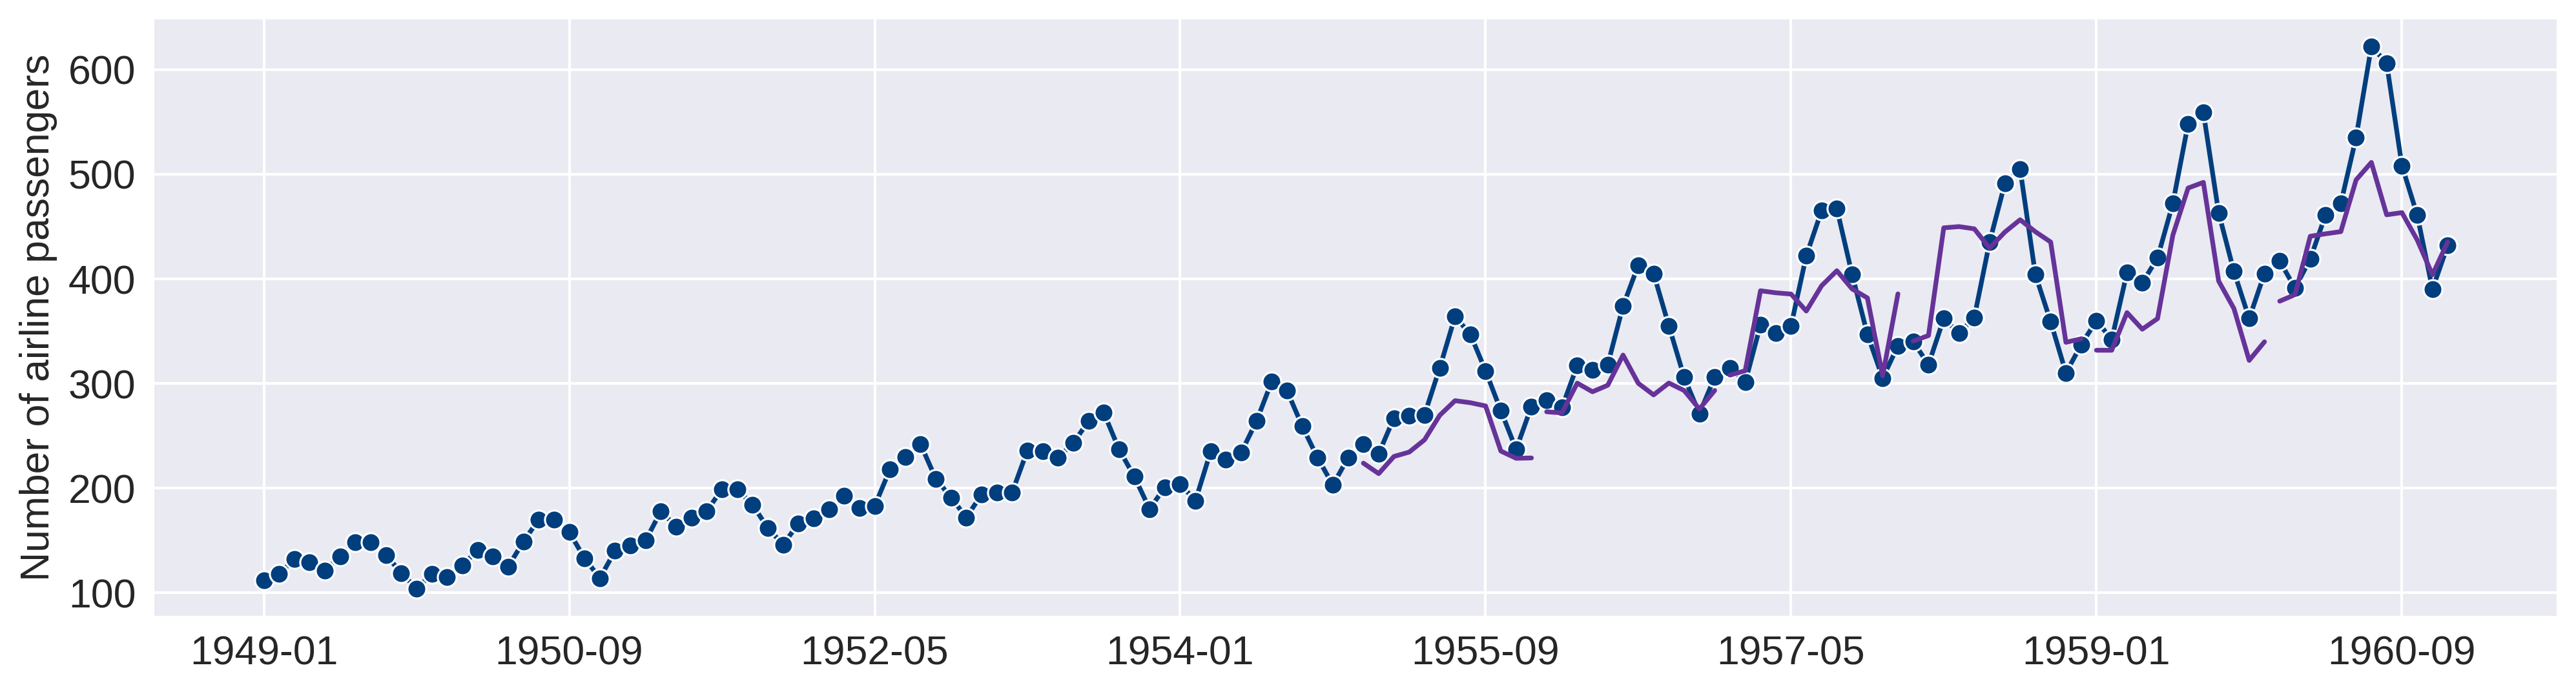

In [108]:
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o"] + 6 * [""],
    #labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(7)],
    colors=[color_dark_blue] + 6 * [purple]
)